## Combining Machine Learning and Optimization with Gurobi

## Machine Learning topics 
Touching the elephant here, but ~~not there~~

Supervised Learning
  * Algorithm selection and hyperparametric optimization
  * KFold assessment vs overfitting
  * Seperating training from prediction 

~~Unsupervised Learning~~

~~Time Series Data~~

~~Deep Learning~~

## Optimization topics

  * Exploratory programming to application deployment
  * Coping with the combinatorial explosion
  * Validating optimization with simulation

# All Under the Banner of Python!

## The Soda Promotion Problem

We have the challenge of designing the upcoming promotion campaign for a Soda Company. The intended objective is to bolster sales while at the same time obeying various business constraints.

## The First Challenge

We need to predict impact of different price points on the expected sales for each type of soda.

To do this, we need to train a soda sales predictor from a historical data table.


### Examine historical data 

In [1]:
import pandas
df_hist = pandas.read_excel("soda_sales_historical_data.xlsx")
df_hist[:5]

,Product,Sales,Cost Per Unit,Easter Included,Super Bowl Included,Christmas Included,Other Holiday,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 Weeks,Sales M-5 weeks
0,11 Down,51.9,1.6625,No,No,Yes,No,80.69,69.19,17.0,22.4,13.5,14.5,28.0
1,Alpine Stream,55.8,2.2725,No,No,Yes,No,80.69,69.19,2.4,2.2,2.0,1.4,0.5
2,Bright,3385.6,1.3475,No,No,Yes,No,80.69,69.19,301.8,188.8,101.4,81.6,213.8
3,Crisp Clear,63.5,1.6600,No,No,Yes,No,80.69,69.19,73.8,69.4,72.8,75.4,57.4
4,Popsi Kola,181.1,1.8725,No,No,Yes,No,80.69,69.19,23.1,22.6,22.1,19.9,23.2


In [2]:
df_hist.shape

(596, 14)

### Convert categorical columns to numeric

In [3]:
from pandas import DataFrame, get_dummies
categorical_columns = ['Product','Easter Included','Super Bowl Included', 'Christmas Included',
                       'Other Holiday']
df_hist = get_dummies(df_hist, prefix={k:"dmy_%s"%k for k in categorical_columns},
                      columns = list(categorical_columns))
df_hist[:5]

,Sales,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 Weeks,Sales M-5 weeks,dmy_Product_11 Down,...,dmy_Product_Koala Kola,dmy_Product_Mr. Popper,dmy_Product_Popsi Kola,dmy_Easter Included_No,dmy_Easter Included_Yes,dmy_Super Bowl Included_No,dmy_Super Bowl Included_Yes,dmy_Christmas Included_No,dmy_Christmas Included_Yes,dmy_Other Holiday_No
0,51.9,1.6625,80.69,69.19,17.0,22.4,13.5,14.5,28.0,1,...,0,0,0,1,0,1,0,0,1,1
1,55.8,2.2725,80.69,69.19,2.4,2.2,2.0,1.4,0.5,0,...,0,0,0,1,0,1,0,0,1,1
2,3385.6,1.3475,80.69,69.19,301.8,188.8,101.4,81.6,213.8,0,...,0,0,0,1,0,1,0,0,1,1
3,63.5,1.6600,80.69,69.19,73.8,69.4,72.8,75.4,57.4,0,...,0,0,0,1,0,1,0,0,1,1
4,181.1,1.8725,80.69,69.19,23.1,22.6,22.1,19.9,23.2,0,...,0,0,1,1,0,1,0,0,1,1


### Picking the right predictor algorithm is of upmost importance.

Hence we examine our choices here in great deal.

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import model_selection
experiments = {"Algorithm":["Ordinary Least Squares", "Regression Tree", 
                            "Big Random Forest", "Random Forest", 
                            "Bagging"], 
               "Objects" : [lambda : LinearRegression(), 
                            lambda : DecisionTreeRegressor(), 
                            lambda : RandomForestRegressor(n_estimators=100), 
                            lambda : RandomForestRegressor(), 
                            lambda : BaggingRegressor()], 
               "Predictions":[[] for _ in range(5)]}
actuals = []

### Resist the temptation to overfit!
Instead, split the samples into train, test subsections.

In [5]:
from sklearn.model_selection import train_test_split
[_.shape for _ in  train_test_split(df_hist.drop("Sales", axis=1), 
                                    df_hist["Sales"], test_size=0.25)]

[(447, 24), (149, 24), (447,), (149,)]

### By repeatedly splitting, training, and testing, you can create a realistic simulation of prediction accuracy.

In [6]:
for _ in range (4):
    train_X, test_X, train_y, test_y = (
        train_test_split(df_hist.drop("Sales", axis=1), 
                         df_hist["Sales"], test_size=0.25))
    for i, obj_factory in enumerate(experiments["Objects"]):
        obj = obj_factory()
        obj.fit(y=train_y,X=train_X)
        experiments["Predictions"][i] += list(obj.predict(test_X))
    actuals += list(test_y)
actuals = pandas.Series(actuals)
experiments["Predictions"] = list(map(pandas.Series, experiments["Predictions"]))

In [7]:
len(actuals), map(len, experiments["Predictions"])

(596, [596, 596, 596, 596, 596])

### Now lets visualize our results

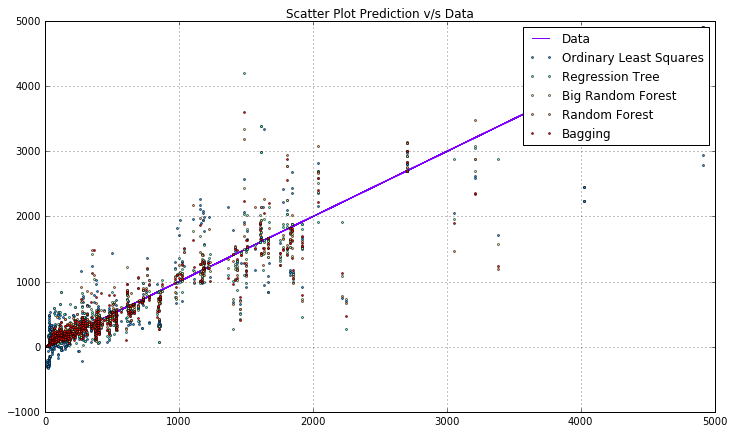

In [8]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,len(experiments)+3)))
plt.figure(figsize=(12,7),dpi=300)
plt.plot(actuals,actuals,c=next(color),markersize=2,label='Data')
for _, row in DataFrame(experiments).iterrows():
    plt.plot(actuals, row["Predictions"],'o',c=next(color),
             markersize=2,label=row['Algorithm'])
plt.title('Scatter Plot Prediction v/s Data')
plt.grid(True)
plt.legend()
plt.show()

### More visualizations

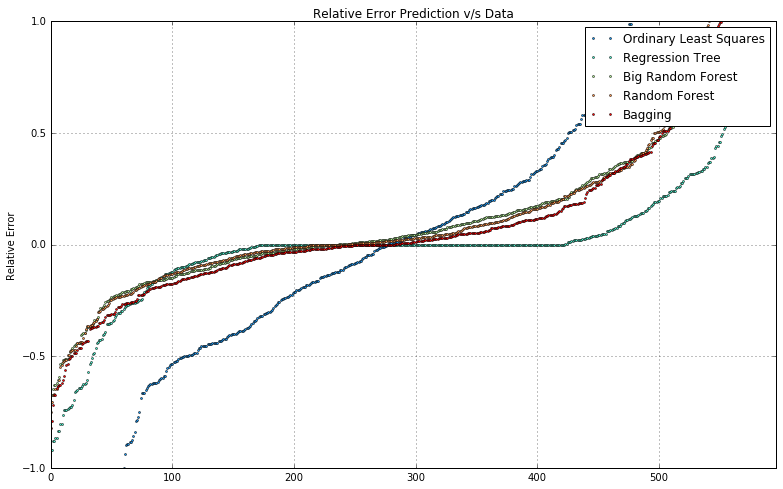

In [9]:
color=iter(cm.rainbow(np.linspace(0,1,len(experiments)+3)))
next(color)
plt.figure(figsize=(13,8),dpi=300)
for index, row in DataFrame(experiments).iterrows():
    relative_error = (row["Predictions"] - actuals) / (1 + abs(actuals))
    plt.plot(np.sort(relative_error),'o',c=next(color),
             markersize=2,label=row['Algorithm'])
plt.title('Relative Error Prediction v/s Data')
plt.ylabel('Relative Error')
plt.grid(True)
plt.legend()
plt.axis([0,len(actuals),-1,1])
plt.show()

### Even more visualizations

In [10]:
def boxplot(algorithm):
    prediction = (experiments["Predictions"]
                  [experiments["Algorithm"].index(algorithm)])
    plt.title(algorithm)
    plt.boxplot( (prediction - actuals) / (1 + abs(actuals))  )
    plt.show()

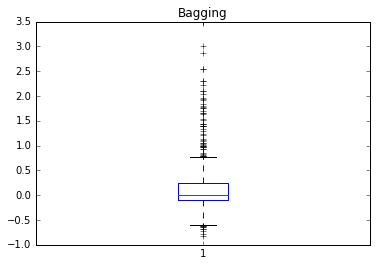

In [11]:
boxplot("Bagging")

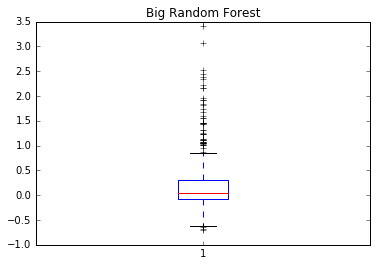

In [12]:
boxplot("Big Random Forest")

### Visualizations only take us so far.

Let's use `model_selection.cross_val_score` to automate the process of train/test split based assessment. (K-Fold Cross Validation)



In [13]:
experiments["Results"] = []
for o in experiments["Objects"]:
    experiments["Results"].append(
        model_selection.cross_val_score(o(), y=df_hist['Sales'], 
                                        X=df_hist.drop("Sales", axis=1),
                                        cv=5).mean())

In [14]:
DataFrame(experiments).drop(["Objects", "Predictions"], axis=1).set_index("Algorithm")

,Results
Algorithm,
Ordinary Least Squares,0.536984
Regression Tree,0.669144
Big Random Forest,0.824711
Random Forest,0.717795
Bagging,0.813617


### Now use the complete historical table to create a predictor object with the best algorithm

In [15]:
fitted = (experiments["Objects"]
          [experiments["Algorithm"].index("Big Random Forest")]().
          fit(y=df_hist["Sales"], X=df_hist.drop("Sales", axis=1)))

### We will make predictions for the "Sales"-less table of current data.

In [16]:
df_superbowl_original = pandas.read_excel("super_bowl_promotion_data.xlsx")
df_superbowl = get_dummies(df_superbowl_original, prefix={k:"dmy_%s"%k for k in categorical_columns},
                      columns = list(categorical_columns))
assert "Sales" not in df_superbowl.columns 
assert {"Sales"}.union(df_superbowl.columns).issubset(set(df_hist.columns))
len(df_superbowl)

36

Note that the current data table might have less categorical range than the historical data. 

In [17]:
for fld in set(df_hist.columns).difference(df_superbowl.columns, {"Sales"}):
    assert fld.startswith("dmy_")
    df_superbowl[fld] = 0

In [18]:
predicted = fitted.predict(df_superbowl)

# Prediction in hand, we commence optimization!

### LaTeX summary of family of equations

$$
\begin{array}{ll}
\max & sales\\
s.t. & sales = \sum\left(f_{b,p} X_{b,p}:{(b,p)\in Prod}\right)\\
     & revenue = \sum\left(f_{b,p}  p X_{b,p}:{(b,p)\in Prod} \right)\\
     & investment = \sum\left(\left(f_{b,p} - f_{b,p_o}\right)_+ p_o X_{b,p}:{(b,p)\in Prod} \right)\\
     & \sum\left(X_{b,p}:{(b,p)\in Prod} \right)=1\quad\forall b\in Soda\\
     & \sum\left(X_{b,p}:{(b,p)\in Prod, p\neq p_o, T(b)=t} \right) \leq max_t\quad\forall t\\
     & investment <= max_{investment}\\
     & X_{b,p}\in\{0,1\}\quad\forall (b,p)\in Prod
\end{array}
$$

### Putting the optimization input set together.

In [19]:
forecast_sales = df_superbowl_original[["Product", "Cost Per Unit"]].copy()
forecast_sales["Sales"] = predicted
forecast_sales.set_index(['Product','Cost Per Unit'], inplace=True)

In [20]:
soda_family = {'11 Down': 'Clear', 'AB Root Beer': 'Dark', 
               'Alpine Stream': 'Clear', 'Bright': 'Clear', 
               'Crisp Clear': 'Clear', 'DC Kola': 'Dark',
               'Koala Kola': 'Dark', 'Mr. Popper': 'Dark', 
               'Popsi Kola': 'Dark'}
family  = set(soda_family[j] for j in soda_family)
soda    = set(j for j in soda_family)
max_prom = {f:2 for f in family}
max_investment = 750

In [21]:
product_prices = set(forecast_sales.index.values)
normal_price = {b:0 for b in soda}
for b,p in product_prices:
    normal_price[b] = max(normal_price[b],p)

Note that not all estimated discounts yield a boost in sales

In [22]:
meaningful_discounts = 0
for b,p in product_prices:
    if forecast_sales.Sales[b,p] > forecast_sales.Sales[b,normal_price[b]]:
        meaningful_discounts += 1
meaningful_discounts, len(forecast_sales) - len(soda)

(21, 27)

### Building a MIP model

In [23]:
import gurobipy as gu
model = gu.Model()
select_price = model.addVars(product_prices,vtype=gu.GRB.BINARY,name='X')
sales = model.addVar(name='sales')
revenue = model.addVar(name='revenue')
investment = model.addVar(ub=max_investment, name='investment')
gusum = gu.quicksum

In [24]:
model.addConstr(sales == select_price.prod(forecast_sales.Sales), name='sales')
model.addConstr(revenue == gusum(forecast_sales.Sales[b,p] * p * 
                                 select_price[b,p] for b,p in product_prices), 
                name='revenue')
model.addConstr(investment == 
                gusum(max(0,forecast_sales.Sales[b,p] - 
                            forecast_sales.Sales[b,normal_price[b]]) *
                        normal_price[b] * select_price[b,p] 
                        for b,p in product_prices),
                name='investment')
model.update()

In [25]:
model.addConstrs((select_price.sum(b,'*') == 1 for b in soda), name='OnePrice')
model.addConstrs((gusum(select_price[b,p] for b,p in product_prices if 
                        soda_family[b] == f and p != normal_price[b] ) 
                  <= max_prom[f] for f in family),
                 name='MaxProm')
model.update()

### Optimize and results

In [27]:
model.setObjective(sales, sense=gu.GRB.MAXIMIZE)
model.optimize()

Optimize a model with 14 rows, 39 columns and 159 nonzeros
Variable types: 3 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+02]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 5750.88
Presolve removed 5 rows and 21 columns
Presolve time: 0.02s
Presolved: 9 rows, 18 columns, 52 nonzeros
Variable types: 0 continuous, 18 integer (18 binary)

Root relaxation: objective 6.071016e+03, 10 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 6071.01589    0    2 5750.87900 6071.01589  5.57%     -    0s
H    0     0                    6033.8860000 6071.01589  0.62%     -    0s
H    0     0                    6034.3470000 6071.01589  0.61%     -    0s
     0     0 6035.50832    0    2 6034.34700 6035.50832  0.02%     -    0s
     0

In [29]:
model.status == gu.GRB.OPTIMAL

True

### Only the paranoid survive
Carefully sanity check the solution.

In [30]:
sales.X, revenue.X, investment.X

(6034.347, 11458.914497499998, 745.1370774999998)

In [32]:
price_selections = {"Product":[], "Price":[], "Is Discount":[], "Family":[]}
for b, p in product_prices:
    if abs(select_price[b,p].X -1) < 0.0001: # i.e. almost one
        price_selections["Product"].append(b)
        price_selections["Price"].append(p)
        price_selections["Is Discount"].append(p < normal_price[b])
        price_selections["Family"].append(soda_family[b])
(DataFrame(price_selections).set_index("Product")
 [["Price", "Is Discount", "Family"]].sort_values("Family"))

,Price,Is Discount,Family
Product,,,
Crisp Clear,1.3125,True,Clear
Bright,1.2900,False,Clear
Alpine Stream,2.2275,False,Clear
11 Down,1.5125,True,Clear
Mr. Popper,2.8475,True,Dark
DC Kola,1.8900,True,Dark
AB Root Beer,3.8425,False,Dark
Popsi Kola,1.7500,False,Dark
Koala Kola,2.5650,False,Dark


### Create a range of predictions to simulate the behavior of our solution under a range of conditions

In [ ]:
simulated_KPI = {'Sales':[],'Revenue':[],'Investment':[]}
Z = model.getAttr('X',X)
for i in range(1000):
    np.random.seed(i)
    fitted = RandomForestRegressor(n_estimators=100,
                                   n_jobs=4).fit(y=df_hist["Sales"],
                                                 X=df_hist.drop("Sales", axis=1))
    forecast = df_superbowl_original[['Product', 'Cost Per Unit']].copy()
    forecast["Sales"] = fitted.predict(df_superbowl)
    forecast = forecast.set_index(['Product','Cost Per Unit'])
    sales, revenue, investment = 0, 0, 0
    for b,p in product_prices:
        sales   += forecast.Sales[b,p] * Z[b,p]
        revenue += forecast.Sales[b,p] * p * Z[b,p]
        investment += max(0,forecast.Sales[b,p] - forecast.Sales[b,normal_price[b]]) * normal_price[b] * Z[b,p]
    simulated_KPI['Sales'].append(sales)
    simulated_KPI['Revenue'].append(revenue)
    simulated_KPI['Investment'].append(investment)